## Goal:
Classify Positive/Negative Sentiment from comments in Ruby Rivlin Facebook Page.

In [1]:
import numpy as np 
import pandas as pd 
import re  
import nltk 
import codecs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
import csv
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google_trans_new import google_translator  
nltk.download('stopwords')  
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn import naive_bayes, svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import operator
from wordcloud import WordCloud
from bidi.algorithm import get_display
import json
from sklearn.preprocessing import scale
from operator import itemgetter
#import eli5
from treeinterpreter import treeinterpreter as ti
import shap
import tensorflow as tf
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramirc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ramirc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ramirc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ramirc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Load data files

In [2]:
#token - Original data
token_train = pd.read_csv("data/token_train.tsv", sep='\t', quoting=csv.QUOTE_NONE, header=None)
token_test = pd.read_csv("data/token_test.tsv", sep='\t', quoting=csv.QUOTE_NONE, header=None)

#morph - Data after morphologic processing
morph_train = pd.read_csv("data/morph_train.tsv", sep='\t', quoting=csv.QUOTE_NONE, header=None)
morph_test = pd.read_csv("data/morph_test.tsv", sep='\t', quoting=csv.QUOTE_NONE, header=None)

#token_eng - Data after english translation (using google translate)
token_train_eng = pd.read_csv("data/token_train_english.csv", header=None)
token_test_eng = pd.read_csv("data/token_test_english.csv", header=None)

In [3]:
print(token_train.shape)
print(morph_train.shape)
print(token_train_eng.shape)

(10244, 2)
(10244, 2)
(10244, 2)


In [4]:
token_train.head()

,0,1
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד...,0
1,איש יקר שלנו,0
2,כל הכבוד והמון בהצלחה,0
3,""" תל חי , רובי . בכל העצב הזה היית קרן אור של ...",0
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0


In [5]:
#frequenct funcrion is getting dataframe and label and returns the top(200) words in thedataframe from the specific label
def frequency(df_freq, label, stop_words=False):
    # Vectorizing reviews set
    if stop_words == False:
        vect = CountVectorizer(analyzer='word')
    else:
        vect = CountVectorizer(stop_words = 'english', analyzer='word')
    
    vect_pos = vect.fit_transform(df_freq[df_freq[1].isin([label])][0])

    # Visualising the high frequency words
    df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
    print(df_freq.nlargest(200, 'frequency'))
    return df_freq.nlargest(200, 'frequency')


# Word frequency and WordCloud - token positive
we can see here that we get words with positive context, but we also get common words and conjunctions

         frequency
הנשיא         1666
את            1292
כל            1028
ישראל         1011
בהצלחה        1008
...            ...
כולם            59
לנשיאות         59
הלוואי          58
חיים            58
אותי            57

[200 rows x 1 columns]


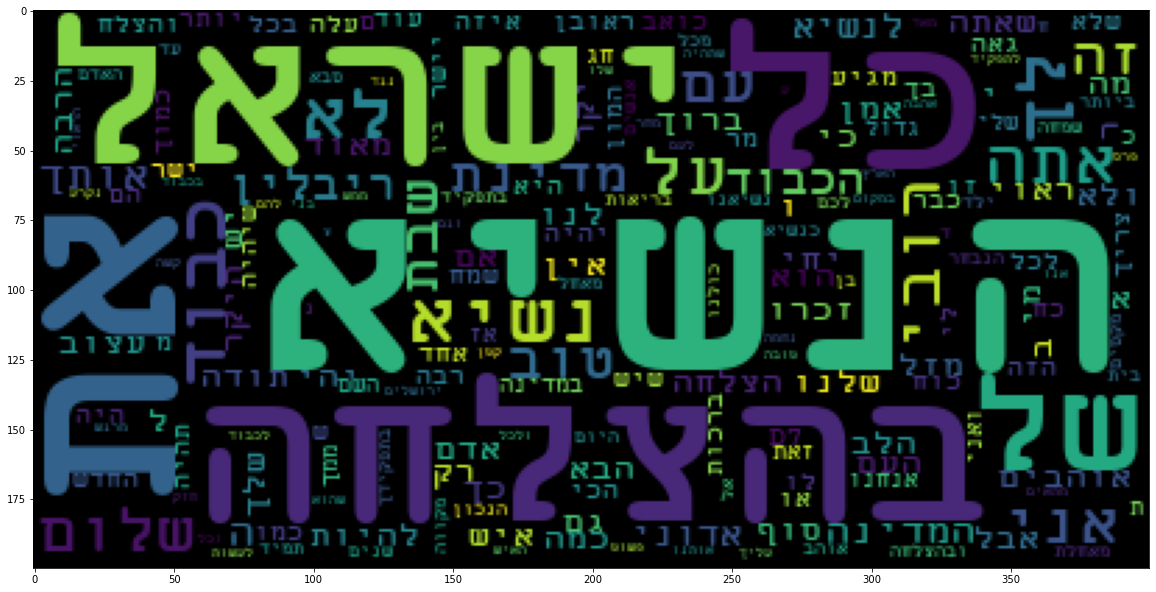

In [6]:
token_pos_freq = frequency(token_train,0)


word_list = token_train[0][token_train[1].isin([0])].tolist()
bow = " ".join(word_list)
bidi_text = get_display(bow)

imdb_wordcloud = WordCloud(font_path = 'C:\Windows\Fonts\courbd.ttf', collocations=False).generate(bidi_text)

plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

# Word frequency and WordCloud - token negative
we can see here that the top words are mainly common words and conjunctions

       frequency
לא          2217
את          2170
של          1235
על          1226
עם          1093
...          ...
אפשר          65
בעולם         65
בשביל         65
ואת           65
מוות          65

[200 rows x 1 columns]


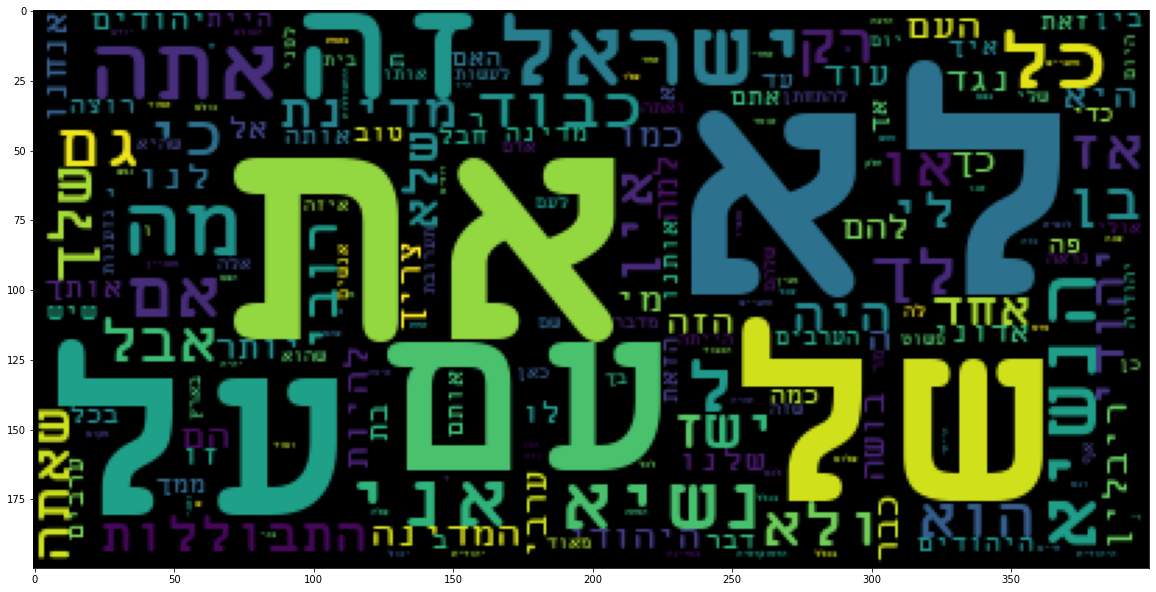

In [7]:
token_neg_freq = frequency(token_train,1)

word_list = token_train[0][token_train[1].isin([1])].tolist()
bow = " ".join(word_list)
bidi_text = get_display(bow)

imdb_wordcloud = WordCloud(font_path = 'C:\Windows\Fonts\courbd.ttf', collocations=False).generate(bidi_text)

plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

# Word frequency and WordCloud - token neutral
we can see here that the top words are mainly common words and conjunctions

        frequency
את            189
של            153
לא            121
www            93
על             91
...           ...
חייבים          7
חיים            7
יארך            7
כאן             7
כלום            7

[200 rows x 1 columns]


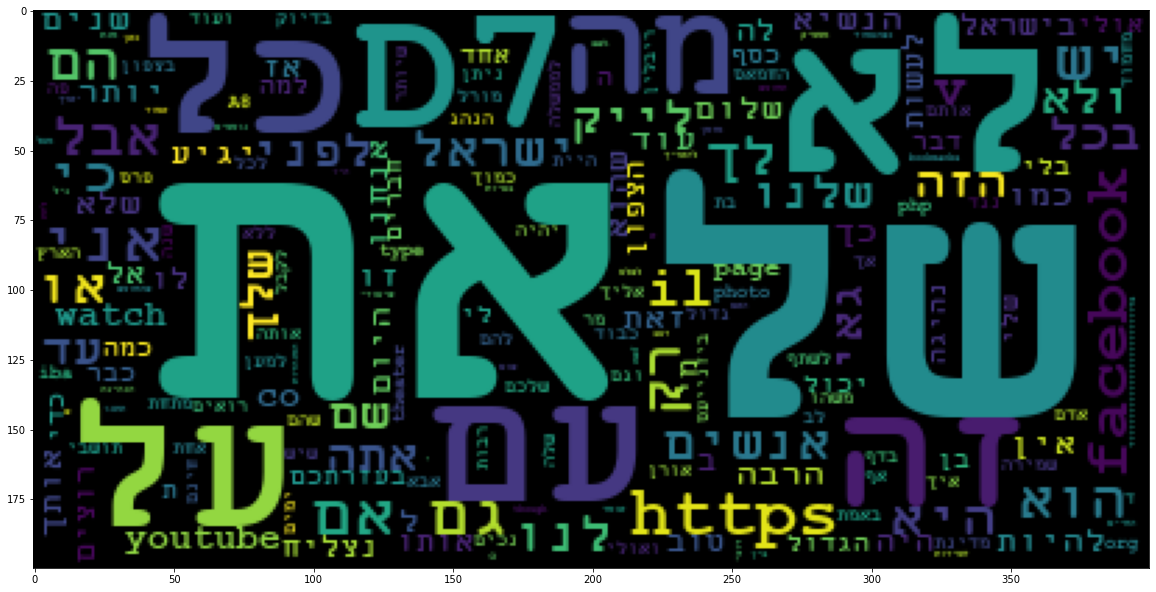

In [8]:
token_neutral_freq = frequency(token_train,2)

word_list = token_train[0][token_train[1].isin([2])].tolist()
bow = " ".join(word_list)
bidi_text = get_display(bow)

imdb_wordcloud = WordCloud(font_path = 'C:\Windows\Fonts\courbd.ttf', collocations=False).generate(bidi_text)

plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

# Word frequency and WordCloud - morph positive
we can see here that we get words with positive context, but we also get common words and conjunctions

       frequency
נשיא        3175
אתה         2927
את          2544
של          1638
כל          1622
...          ...
אמיתי         58
ברכה          58
דברים         58
ילדים         58
יתן           58

[200 rows x 1 columns]


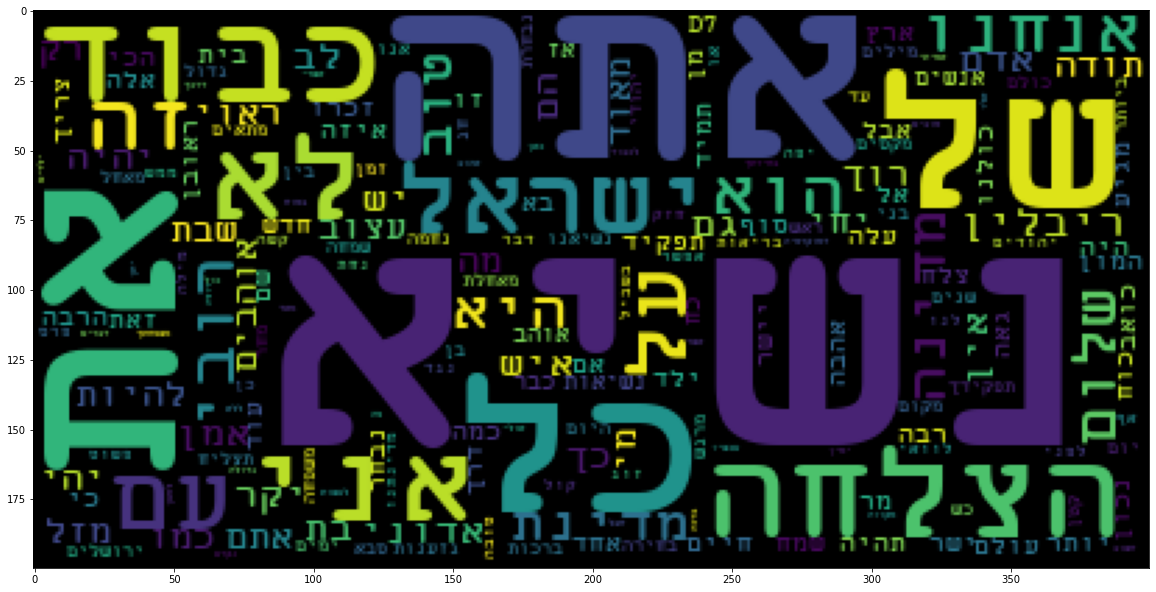

In [9]:
morph_pos_freq = frequency(morph_train, 0)

word_list = morph_train[0][morph_train[1].isin([0])].tolist()
bow = " ".join(word_list)
bidi_text = get_display(bow)

imdb_wordcloud = WordCloud(font_path = 'C:\Windows\Fonts\courbd.ttf', min_word_length=2, collocations=False).generate(bidi_text)

plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

# Word frequency and WordCloud - morph negative
we can see here that the top words are mainly common words and conjunctions

       frequency
את          3533
לא          2888
אתה         2617
של          2032
זה          1685
...          ...
חמאס          63
כלל           63
לשמור         63
הרי           62
עדיף          62

[200 rows x 1 columns]


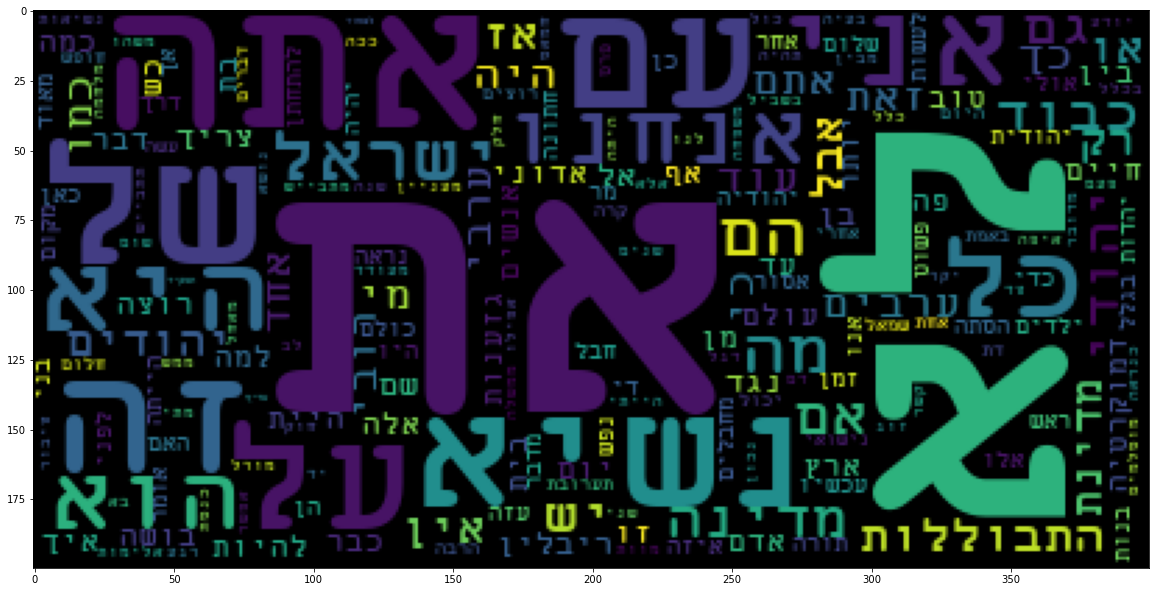

In [10]:
morph_neg_freq = frequency(morph_train, 1)

word_list = morph_train[0][morph_train[1].isin([1])].tolist()
bow = " ".join(word_list)
bidi_text = get_display(bow)

imdb_wordcloud = WordCloud(font_path = 'C:\Windows\Fonts\courbd.ttf', min_word_length=2, collocations=False).generate(bidi_text)

plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

# Word frequency and WordCloud - morph neutral
we can see here that the top words are mainly common words and conjunctions

       frequency
את           302
של           216
לא           166
אתה          145
כל           135
...          ...
דין            7
האם            7
הגדול          7
הייתה          7
הן             7

[200 rows x 1 columns]


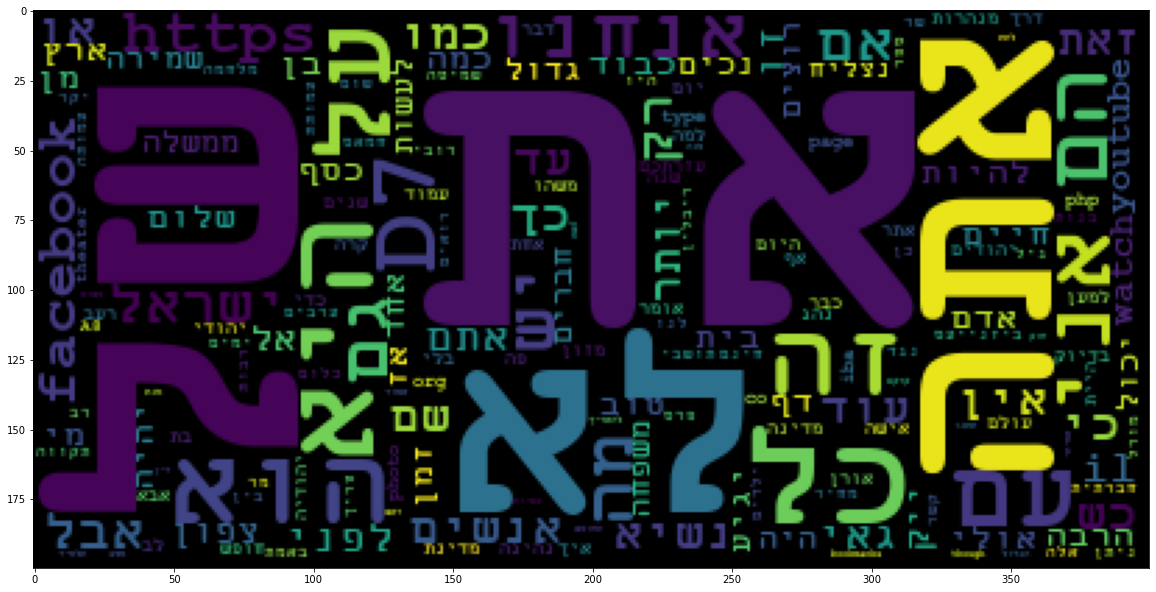

In [11]:
morph_neutral_freq = frequency(morph_train, 2)

word_list = morph_train[0][morph_train[1].isin([2])].tolist()
bow = " ".join(word_list)
bidi_text = get_display(bow)

imdb_wordcloud = WordCloud(font_path = 'C:\Windows\Fonts\courbd.ttf', min_word_length=2, collocations=False).generate(bidi_text)

plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

**Build vocabulary from words that unique for each class, words that are significant in one class but not in the other classes**

**for the basic naive classifier**

In [12]:
token_vocabulary = []
for word in token_pos_freq.index:
    if (word not in token_neg_freq.index) and (word not in token_neutral_freq.index):
        token_vocabulary.append(word)
for word in token_neg_freq.index:
    if (word not in token_pos_freq.index) and (word not in token_neutral_freq.index):
        token_vocabulary.append(word)
for word in token_neutral_freq.index:
    if (word not in token_pos_freq.index) and (word not in token_neg_freq.index):
        token_vocabulary.append(word)

In [13]:
morph_vocabulary = []
for word in morph_pos_freq.index:
    if (word not in morph_neg_freq.index) and (word not in morph_neutral_freq.index):
        morph_vocabulary.append(word)
for word in token_neg_freq.index:
    if (word not in morph_pos_freq.index) and (word not in morph_neutral_freq.index):
        morph_vocabulary.append(word)
for word in token_neutral_freq.index:
    if (word not in morph_pos_freq.index) and (word not in morph_neg_freq.index):
        morph_vocabulary.append(word)
morph_vocabulary = list(dict.fromkeys(morph_vocabulary))

## Plot train data sentiments distribution
We can see that most of the comments are possitive

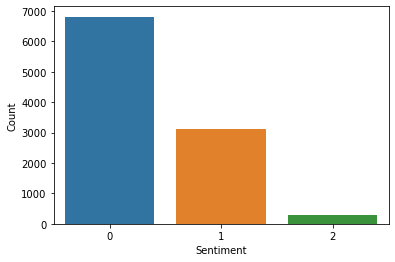

In [14]:
ax = sns.countplot(x=1, data=token_train);
ax.set(xlabel='Sentiment', ylabel='Count')
plt.show()

## FIRST MODEL
Using Random Forest classifier based on TD-IDF

## Prepare the data for models

In [15]:
#token_train_eng = token_train_eng[token_train_eng[1] < 2]
#token_test_eng = token_test_eng[token_test_eng[1] < 2]

In [16]:
#Split all data sets to the comments(X) and the sentimnet(y) 

'''
X_token_train = token_train.iloc[:, 0].values
y_token_train = token_train.iloc[:, 1].values
X_token_test = token_test.iloc[:, 0].values
y_token_test = token_test.iloc[:, 1].values

X_morph_train = morph_train.iloc[:, 0].values
y_morph_train = morph_train.iloc[:, 1].values
X_morph_test = morph_test.iloc[:, 0].values
y_morph_test = morph_test.iloc[:, 1].values


X_token_train_eng = token_train_eng.iloc[:, 0].values
y_token_train_eng = token_train_eng.iloc[:, 1].values
X_token_test_eng = token_test_eng.iloc[:, 0].values
y_token_test_eng = token_test_eng.iloc[:, 1].values'''

'\nX_token_train = token_train.iloc[:, 0].values\ny_token_train = token_train.iloc[:, 1].values\nX_token_test = token_test.iloc[:, 0].values\ny_token_test = token_test.iloc[:, 1].values\n\nX_morph_train = morph_train.iloc[:, 0].values\ny_morph_train = morph_train.iloc[:, 1].values\nX_morph_test = morph_test.iloc[:, 0].values\ny_morph_test = morph_test.iloc[:, 1].values\n\n\nX_token_train_eng = token_train_eng.iloc[:, 0].values\ny_token_train_eng = token_train_eng.iloc[:, 1].values\nX_token_test_eng = token_test_eng.iloc[:, 0].values\ny_token_test_eng = token_test_eng.iloc[:, 1].values'

In [17]:
#proccess_text function will get text array and clean it with regex expressions
def process_text(arr, lang):
    processed_arr = []
    
    if lang=="he":
        for text in range(0, len(arr)):  
            processed_text = re.sub(r'[\a-z]+', ' ', str(arr[text]))
            processed_arr.append(processed_text)
            
    elif lang=="eng":
        for text in range(0, len(arr)):  
            # Remove all the special characters
            processed_text = re.sub(r'\W', ' ', str(arr[text]))

            # Remove all digits
            #processed_text = re.sub(r'\d+', ' ', processed_text)

            # remove all single characters
            processed_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_text)

            # Remove single characters from the start
            processed_text = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_text) 

            # Substituting multiple spaces with single space
            processed_text= re.sub(r'\s+', ' ', processed_text, flags=re.I)

            # Removing prefixed 'b'
            processed_text = re.sub(r'^b\s+', '', processed_text)

            # Converting to Lowercase
            processed_text = processed_text.lower()
            processed_arr.append(processed_text)
    
    return processed_arr

In [18]:
#Clean Datasets

'''X_token_train_processed = process_text(X_token_train,"he")
X_token_test_processed = process_text(X_token_test,"he")

X_morph_train_processed = process_text(X_morph_train,"he")
X_morph_test_processed = process_text(X_morph_test,"he")

X_token_train_eng_processed = token_train_eng(X_token_train_eng,"eng")
X_token_test_eng_processed = process_text(X_token_test_eng,"eng")'''

'X_token_train_processed = process_text(X_token_train,"he")\nX_token_test_processed = process_text(X_token_test,"he")\n\nX_morph_train_processed = process_text(X_morph_train,"he")\nX_morph_test_processed = process_text(X_morph_test,"he")\n\nX_token_train_eng_processed = token_train_eng(X_token_train_eng,"eng")\nX_token_test_eng_processed = process_text(X_token_test_eng,"eng")'

In [19]:
#token_train_eng[0] = process_text(token_train_eng[0],"eng")

In [20]:
#token_train_eng[:5]

In [21]:
token_train[0] = process_text(token_train[0],"he")
token_test[0] = process_text(token_test[0],"he")

morph_train[0] = process_text(morph_train[0],"he")
morph_test[0] = process_text(morph_test[0],"he")

token_train_eng[0] = process_text(token_train_eng[0],"eng")
token_test_eng[0] = process_text(token_test_eng[0],"eng")

In [22]:
#Split all data sets to the comments(X) and the sentimnet(y) 


X_token_train = token_train.iloc[:, 0].values
y_token_train = token_train.iloc[:, 1].values
X_token_test = token_test.iloc[:, 0].values
y_token_test = token_test.iloc[:, 1].values

X_morph_train = morph_train.iloc[:, 0].values
y_morph_train = morph_train.iloc[:, 1].values
X_morph_test = morph_test.iloc[:, 0].values
y_morph_test = morph_test.iloc[:, 1].values


X_token_train_eng = token_train_eng.iloc[:, 0].values
y_token_train_eng = token_train_eng.iloc[:, 1].values
X_token_test_eng = token_test_eng.iloc[:, 0].values
y_token_test_eng = token_test_eng.iloc[:, 1].values

# New Model - Naive classifier 
**based on the vocabularies that i build with the unique words for each class**

In [23]:
#token based

In [24]:
#vectorize by the vocabulary
count_vect_token = CountVectorizer(vocabulary=token_vocabulary)
count_vect_token.fit(X_token_train)

CountVectorizer(vocabulary=['בהצלחה', 'שבת', 'איש', 'אמן', 'הלב', 'יחי', 'ברוך',
                            'מזל', 'יקר', 'יהי', 'הצלחה', 'תודה', 'אוהבים',
                            'זכרו', 'ראוי', 'עצוב', 'סוף', 'היקר', 'הבא',
                            'ראובן', 'רבה', 'ישר', 'עלה', 'הכי', 'שמח', 'המון',
                            'כואב', 'החדש', 'והצלח', 'כוח', ...])

In [25]:
X_token_train_counts = count_vect_token.transform(X_token_train)
X_token_test_counts = count_vect_token.transform(X_token_test)

In [26]:
token_my_voc_train = pd.DataFrame.sparse.from_spmatrix(X_token_train_counts)
token_my_voc_test = pd.DataFrame.sparse.from_spmatrix(X_token_test_counts)

In [27]:
token_my_voc_train_arr = token_my_voc_train.to_numpy()
token_my_voc_test_arr = token_my_voc_test.to_numpy()

In [28]:
#use MultinomialNB for the classification
MNB = MultinomialNB()
MNB.fit(token_my_voc_train_arr, y_token_train)
y_pred = MNB.predict(token_my_voc_test_arr)
print("Accuracy:",metrics.accuracy_score(y_token_test, y_pred))

Accuracy: 0.808984375


# False Positives, True Positives - Explantion

In [29]:
# print poisitive rows that classified wrong
pos_org = np.where(y_token_test == 0)
count = 0
for i in pos_org[0]:
    pos_pred = np.where(y_pred == 0)
    if i not in pos_pred[0]:
        print(i)
        print(X_token_test[i])
        rec_words = np.where(token_my_voc_test_arr[i] != 0)
        print("classified words:")
        for word in rec_words[0]:
            print(count_vect_token.get_feature_names()[word])
        count += 1
        print("\n")
print(count)

25
אדוני הנשיא כל בנאדם צריך לחתום על זה צריך להוציא חוק בכלל שכול בנדם שנממתו עלתה למעלה צריך ליתרום את גופו לאנשים אחרים לא צריך את זה למתה לאוציא חוק וזה בסדר לי יש את זה לפנה שנה אני חתמתי ואני מציע לכולם בבקשה תחתמו כמו שאתם עוזרים לאנשים שאם בחיים תעזרו לאנשים גם שאתם מתים חשוב
classified words:
בכלל
וזה


33
דיי לדתיות הפנאטית הזאת שמפלגת בני אדם בלי שום סיבה הגיונית יש פה מאבק בין מחנה שרוצה אחווה אנושית למחנה שרוצה פילוג אנושי לא קשה לראות איזה צד יתאים יותר לעולם שמח 
classified words:
שמח
קשה
הזאת
שום
בלי


35
 מצויין אתה בעמדה יוצאת דופן לתת תקווה לכל אלה מאיתנו שעוד לא הפכו לגזענים וקנאים ליהדותם בבקשה אל תתן לפסיכים פה לערער אותך אתה אחד ממעוזות המתינות והשפיות היחידים שנשארו לנו בקרב נבחרי הציבור חייבים לדעת שיש לעם הזה עוד סיכוי להיות עם שראוי להתקיים 
classified words:
לתת
חייבים


38
 אני אוהבת את הנשיא הנבחר הזה כל כך קרוב לעמו כמו אבא טוב לב כזה שחולק אתנו רגשות שינוי מרנין לעומת הקודם שעל פי הדיווחים נהנה ממנעמי שלטון בתקציב שערורייתי ולפי מה שהרגשתי היה ונותר מנות

**We can see that in some rows that classified wrong we can find words that can interpreted as negative for example:**
- row 33 - קשה
- row 57 - ערבי
- row 73 - תתבייש
- row 203 - תערובת

**but in this model we have a lot of rows that we don't recognize enough words or that we recognized word as negative but they aren't negative necessity**

In [30]:
# print negative rows that classified wrong
neg_org = np.where(y_token_test == 1)
count = 0
for i in neg_org[0]:
    neg_pred = np.where(y_pred == 1)
    if i not in neg_pred[0]:
        print(i)
        print(X_token_test[i])
        rec_words = np.where(token_my_voc_test_arr[i] != 0)
        print("classified words:")
        for word in rec_words[0]:
            print(count_vect_token.get_feature_names()[word])
        count += 1
        print("\n")
print(count)

27
 זה לא קשור לגזענות זה קשור להתבוללות שבגללה קיבלנו עונש את השואה אם בחוקותי תלכו ואם לא אז 
classified words:


72
זוהרה כולנו כהנא 
classified words:
כולנו


75
 עכשיו נהיית נשיא כדי שנשמע את השטויות שאתה כותב עזוב תהנה מהמשכורת ותשאיר אותנו עם הצרות שהממשלה עושה לנו תודה 
classified words:
תודה
עכשיו


96
סע סע ללפלנד עשית תפדיחה שלך
classified words:


98
 לכל מי שקורא את התגובות השפויות ולא מסכים איתם שידע שהנשיא של המדינה שלו סובר כמוהו למרבה הצער 
classified words:


107
 זה כמובן לא טרור וגם לא מסכן את קיומנו אז לא צריך לגנות 
classified words:


109
רובי ריבלין אני בז לך 
classified words:


121
 לתשומת ליבכם למטה מופיעים שמות המכהנים במועצה של ארגון בצלם כשיגידו לכם ויקראו לכם לבוא להצגה לקנות ספר הרצאה וכל דבר שהאנשים הלא מכובדים האלה יקדמו בתקשורת תזכרו שהם חברים במועצה הציבורית של הארגון אני לא מקדם כאן חרם אני קורא לכל אחד לפעול לפי מצפונו ולפי רחשי ליבו אני באופן אישי לא אקדם לא אפרנס ולא אעזור לאף אחד מהאנשים האלו אשר בעיני בוגדים בעמם ופוגעים באינטרסים של המדינה בה 

1905
הנה למשל במחילה מכבודך אחד סראבק ערס חפרתם על זה יבני זונות וראדי עוד יותר בן זונה פוליטיקאים מסריחים שמחפשים במה השם במגיבים 
classified words:


1906
אל תלמד אותנו תורה חצוף 
classified words:


1916
 אדוני הנשיא הבא בירושלים יושבים שופטים שהם גיס חמישי בכנסת יש ממשלה של אפסים סמרטוטים פחדנים ובכנסת יושבים יהודונים קטנים פחדנים וכנועים 
classified words:
הבא


1919
נבחרת ונהיית שמאלן ביבי צדק
classified words:


1930
מי מהגויים התפלל על הבנים רק אנחנו לבין עצמינו בוכים על אחינו שיחזרו ממש לא הגויים אצלהם אולי זאת צביעות 
classified words:


1935
 מר נתניהו את משה יעלון מחר בשעה בבוקר המחבלים יפתחו בהתקפה טילים ופצמ רים אל תכניס את הילדים אני לבד אלחם בם לא רוצים לראות שוב הלוויות האם זה ברור לך אל תכניס את הילדים שוב הבורא ילחם לכם ואתם תחרישון 
classified words:
מחר


1949
 כבוד הנשיא אל תזרוק עלינו פרחים ואל תזרוק עלינו אבנים 
classified words:


2000
אתחיל להאמין כאשר יפסיקו לשטוף את מוחם של הילדים בשנאה כלפינו במערכת החינוך הפלסטינית
classified words:


2029
 דיי עם זה לנו ל

**We can see that in some rows that classified wrong we can find words that can interpreted as positive for example:**
- row 121 - טובה, חברים
- row 129 - לייק
- row 138 - יקר
- row 203 - תערובת

**We can see also that we have a lot of rows that we didn't recognize any word - probably because the vocabulary isn't contain enough words**

In [31]:
#morph based

In [32]:
count_vect_morph = CountVectorizer(vocabulary=morph_vocabulary)
count_vect_morph.fit(X_morph_train)

CountVectorizer(vocabulary=['הצלחה', 'איש', 'אמן', 'ראוי', 'יחי', 'מזל', 'רוך',
                            'יהי', 'תודה', 'שבת', 'אוהבים', 'עצוב', 'תפקיד',
                            'סוף', 'זכרו', 'ישר', 'ראובן', 'רבה', 'המון', 'הכי',
                            'עלה', 'שמח', 'חדש', 'כואב', 'נבחר', 'צלח', 'ילד',
                            'מגיע', 'יישר', 'כוח', ...])

In [33]:
X_morph_train_counts = count_vect_morph.transform(X_morph_train)
X_morph_test_counts = count_vect_morph.transform(X_morph_test)

In [34]:
morph_my_voc_train = pd.DataFrame.sparse.from_spmatrix(X_morph_train_counts)
morph_my_voc_test = pd.DataFrame.sparse.from_spmatrix(X_morph_test_counts)

In [35]:
morph_my_voc_train_arr = morph_my_voc_train.to_numpy()
morph_my_voc_test_arr = morph_my_voc_test.to_numpy()

In [36]:
MNB = MultinomialNB()
MNB.fit(morph_my_voc_train_arr, y_morph_train)
y_pred = MNB.predict(morph_my_voc_test_arr)
print("Accuracy:",metrics.accuracy_score(y_token_test, y_pred))

Accuracy: 0.7859375


**We see that also with naive classifier that based on unique words of each class we get 80%~ accuracy**

## FIRST MODEL
Using Random Forest classifier based on TD-IDF

Create feature vectors containing TF-IDF values
- max_features - The number of words that we will create feature for.
- min_df - Specify that a word should be occur at least 5 times to treat as feature
- max_df = Specify that a word will not occur in more of 70% of the data

In [37]:
tfidf_token_converter = TfidfVectorizer(max_features=3000, min_df=5, max_df=0.7)  

tfidf_morph_converter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)  

tfidf_token_eng_converter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)  

In [38]:
#We will use only the train data to fit (create the features) and than we will transform both train and dataset.

tfidf_token_converter.fit(X_token_train)
X_token_train = tfidf_token_converter.transform(X_token_train).toarray()
X_token_test = tfidf_token_converter.transform(X_token_test).toarray()

tfidf_morph_converter.fit(X_morph_train)
X_morph_train = tfidf_morph_converter.transform(X_morph_train).toarray()
X_morph_test = tfidf_morph_converter.transform(X_morph_test).toarray()

tfidf_token_eng_converter.fit(X_token_train_eng)
X_token_train_eng = tfidf_token_eng_converter.transform(X_token_train_eng).toarray()
X_token_test_eng = tfidf_token_eng_converter.transform(X_token_test_eng).toarray()

In [39]:
#get top weighting feature (the more rare words get more weight in tdidf) and words with the lowest weight (more common words)
def get_edge_words(converter, amount):
    indices = np.argsort(converter.idf_)[::-1]
    features = converter.get_feature_names()
    top_features = [features[i] for i in indices[:amount]]
    low_features = [features[i] for i in indices[(len(features)-amount):]]
    print("Top weight words:")
    print(top_features)
    print("\nLow weight words:")
    print(low_features)

In [40]:
get_edge_words(tfidf_token_converter, 20)

Top weight words:
['בצפון', 'חו', 'גרים', 'ואוהד', 'נכים', 'ינו', 'מידם', 'יך', 'ביזנייעס', 'זר', 'ולתת', 'משותפים', 'גילויי', 'מהציבור', 'בלה', 'המסר', 'יקבלו', 'ואחר', 'המנהרות', 'עניים']

Low weight words:
['גם', 'מדינת', 'ריבלין', 'מה', 'רובי', 'בהצלחה', 'אני', 'לך', 'זה', 'עם', 'כבוד', 'אתה', 'ישראל', 'על', 'נשיא', 'כל', 'של', 'לא', 'את', 'הנשיא']


In [41]:
get_edge_words(tfidf_morph_converter, 20)

Top weight words:
['יך', 'בלה', 'הוראה', 'עמותה', 'תו', 'עזרתכם', 'משא', 'עמלק', 'עסקים', 'אימא', 'תחבורה', 'בנך', 'לבקר', 'נהרגו', 'רעב', 'יהוה', 'משכורות', 'יה', 'אוטובוס', 'שידור']

Low weight words:
['יש', 'מדינה', 'מה', 'רובי', 'היא', 'הוא', 'אנחנו', 'הצלחה', 'ישראל', 'על', 'זה', 'אני', 'כבוד', 'עם', 'כל', 'לא', 'של', 'אתה', 'את', 'נשיא']


In [42]:
get_edge_words(tfidf_token_eng_converter, 20)

Top weight words:
['zvi', 'test', 'hunger', 'hungry', '9e', 'iba', 'thee', 'avraham', 'remained', 'salvation', 'driver', 'flock', 'unclean', 'strengthens', 'a0', 'liberate', 'threat', 'anthem', 'judges', 'sanctification']

Low weight words:
['who', 'have', 'with', 'israel', 'your', 'be', 'it', 'for', 'are', 'will', 'that', 'not', 'is', 'in', 'president', 'to', 'you', 'of', 'and', 'the']


## Build Classifier
I will use random forest to classify the data

In [43]:
token_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
token_classifier.fit(X_token_train, y_token_train)

morph_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
morph_classifier.fit(X_morph_train, y_morph_train)

token_eng_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
token_eng_classifier.fit(X_token_train_eng, y_token_train_eng)

RandomForestClassifier(random_state=0)

## Predict

In [44]:
token_predictions = token_classifier.predict(X_token_test)
morph_predictions = morph_classifier.predict(X_morph_test)
token_eng_predictions = token_eng_classifier.predict(X_token_test_eng)

We can see that we get similiar results in all datasets ~92% accuracy.

In [45]:
print("token model")
print(confusion_matrix(y_token_test, token_predictions))  
print(classification_report(y_token_test, token_predictions))  
print(accuracy_score(y_token_test, token_predictions))

print("\nmorph model")
print(confusion_matrix(y_morph_test, morph_predictions))  
print(classification_report(y_morph_test, morph_predictions))  
print(accuracy_score(y_morph_test, morph_predictions))

print("token_eng model")
print(confusion_matrix(y_token_test_eng, token_eng_predictions))  
print(classification_report(y_token_test_eng, token_eng_predictions))  
print(accuracy_score(y_token_test_eng, token_eng_predictions))

token model
[[1622   74    2]
 [  91  698    1]
 [  20   15   37]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1698
           1       0.89      0.88      0.89       790
           2       0.93      0.51      0.66        72

    accuracy                           0.92      2560
   macro avg       0.92      0.78      0.83      2560
weighted avg       0.92      0.92      0.92      2560

0.920703125

morph model
[[1634   61    3]
 [ 100  690    0]
 [  17   18   37]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1698
           1       0.90      0.87      0.89       790
           2       0.93      0.51      0.66        72

    accuracy                           0.92      2560
   macro avg       0.92      0.78      0.83      2560
weighted avg       0.92      0.92      0.92      2560

0.922265625
token_eng model
[[1643   48    7]
 [ 102  684    4]
 [  16   15   41]]
        

We can see the diffrences between the features of the datasets

# print feature importance graph of the random forest model

In [62]:
def print_feature_importances(df, classifier, converter):

    # Preparing variables
    importances = classifier.feature_importances_
    feature_names = converter.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(20):
        print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

    # Plot the feature importances of the forest
    plt.figure(figsize = (20,20))
    plt.title("Feature importances")
    plt.bar(range(100), importances[indices[:100]],
           color="r", align="center")
    plt.xticks(range(100), sorted_features[:100], rotation=90)
    plt.xlim([-1, 100])
    plt.show()

    return()

Feature ranking:
feature 1577 : לא (0.035327)
feature 1986 : מה (0.019590)
feature 1208 : זה (0.016594)
feature 197 : את (0.015729)
feature 250 : בהצלחה (0.015220)
feature 982 : התבוללות (0.014118)
feature 2429 : עם (0.012721)
feature 2415 : על (0.010512)
feature 265 : בושה (0.010308)
feature 858 : הנשיא (0.009269)
feature 141 : אם (0.008136)
feature 2456 : ערבי (0.007780)
feature 198 : אתה (0.007528)
feature 1378 : יהודי (0.007200)
feature 1784 : למה (0.007169)
feature 2774 : של (0.007035)
feature 59 : אז (0.006805)
feature 2989 : תתבייש (0.006690)
feature 747 : היהודי (0.006499)
feature 2394 : עוד (0.006316)


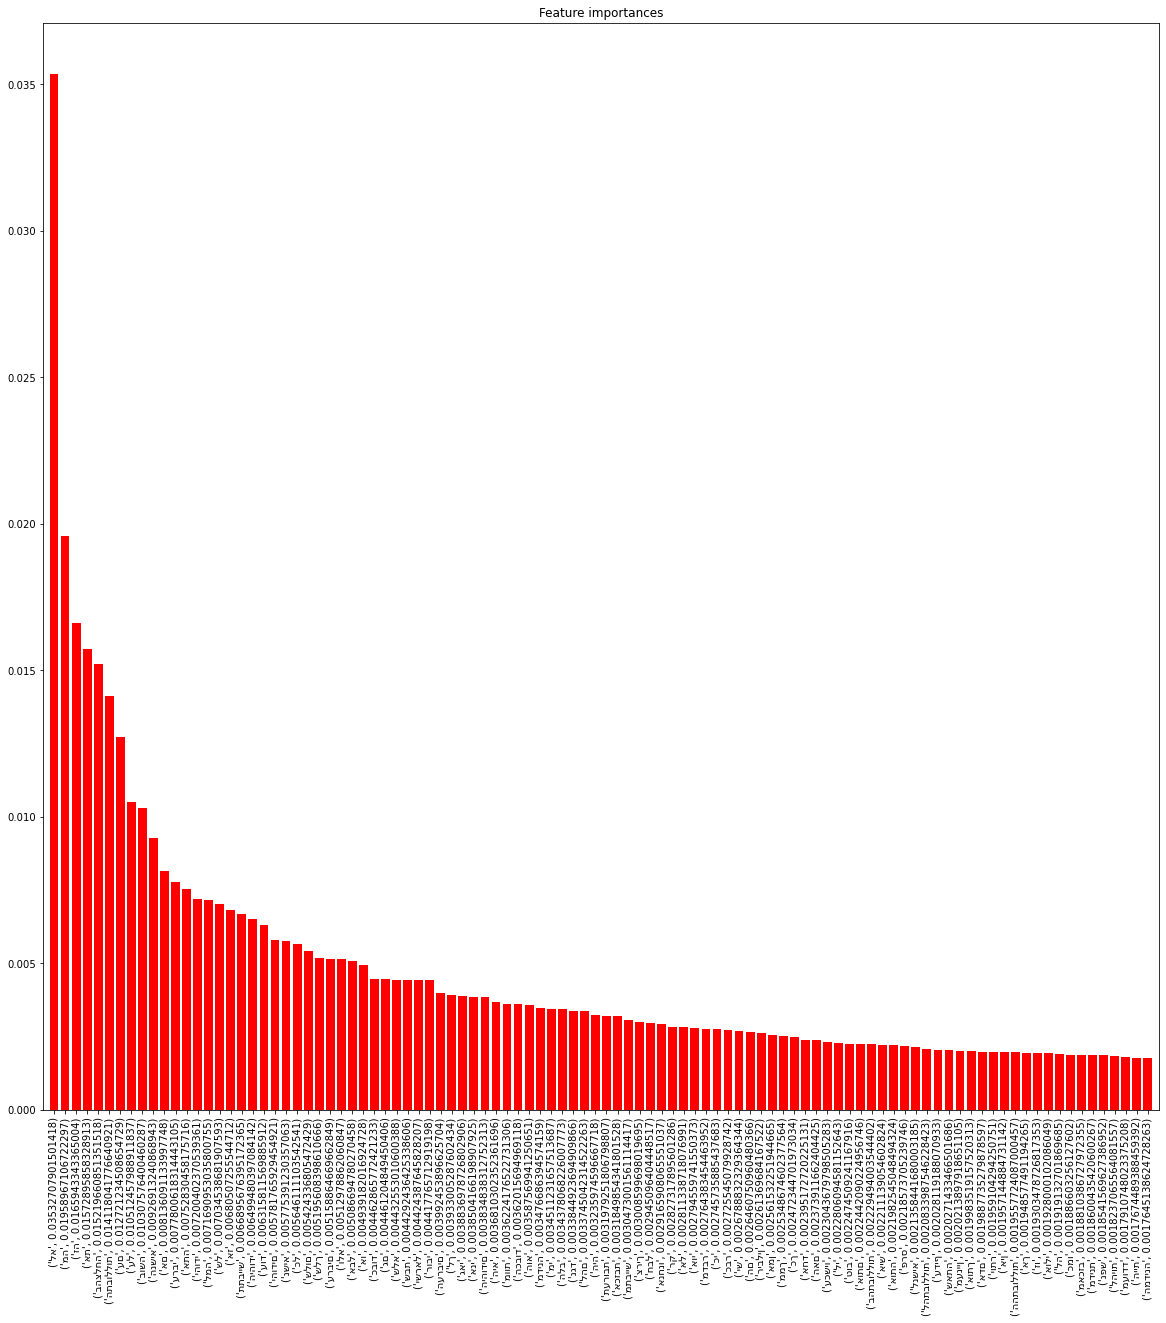

()

In [47]:
print_feature_importances(X_token_train, token_classifier, tfidf_token_converter)

Feature ranking:
feature 873 : לא (0.039690)
feature 501 : התבוללות (0.025627)
feature 1118 : מה (0.023774)
feature 488 : הצלחה (0.023037)
feature 513 : זה (0.018891)
feature 193 : את (0.016008)
feature 1446 : נשיא (0.014583)
feature 692 : יהודי (0.013583)
feature 1568 : ערבים (0.012707)
feature 448 : היא (0.011849)
feature 1536 : עם (0.011661)
feature 696 : יהודים (0.010887)
feature 221 : בושה (0.010876)
feature 1563 : ערבי (0.010639)
feature 1526 : על (0.010148)
feature 470 : הם (0.010034)
feature 1834 : של (0.009807)
feature 194 : אתה (0.009718)
feature 797 : כבוד (0.009610)
feature 139 : אם (0.007966)


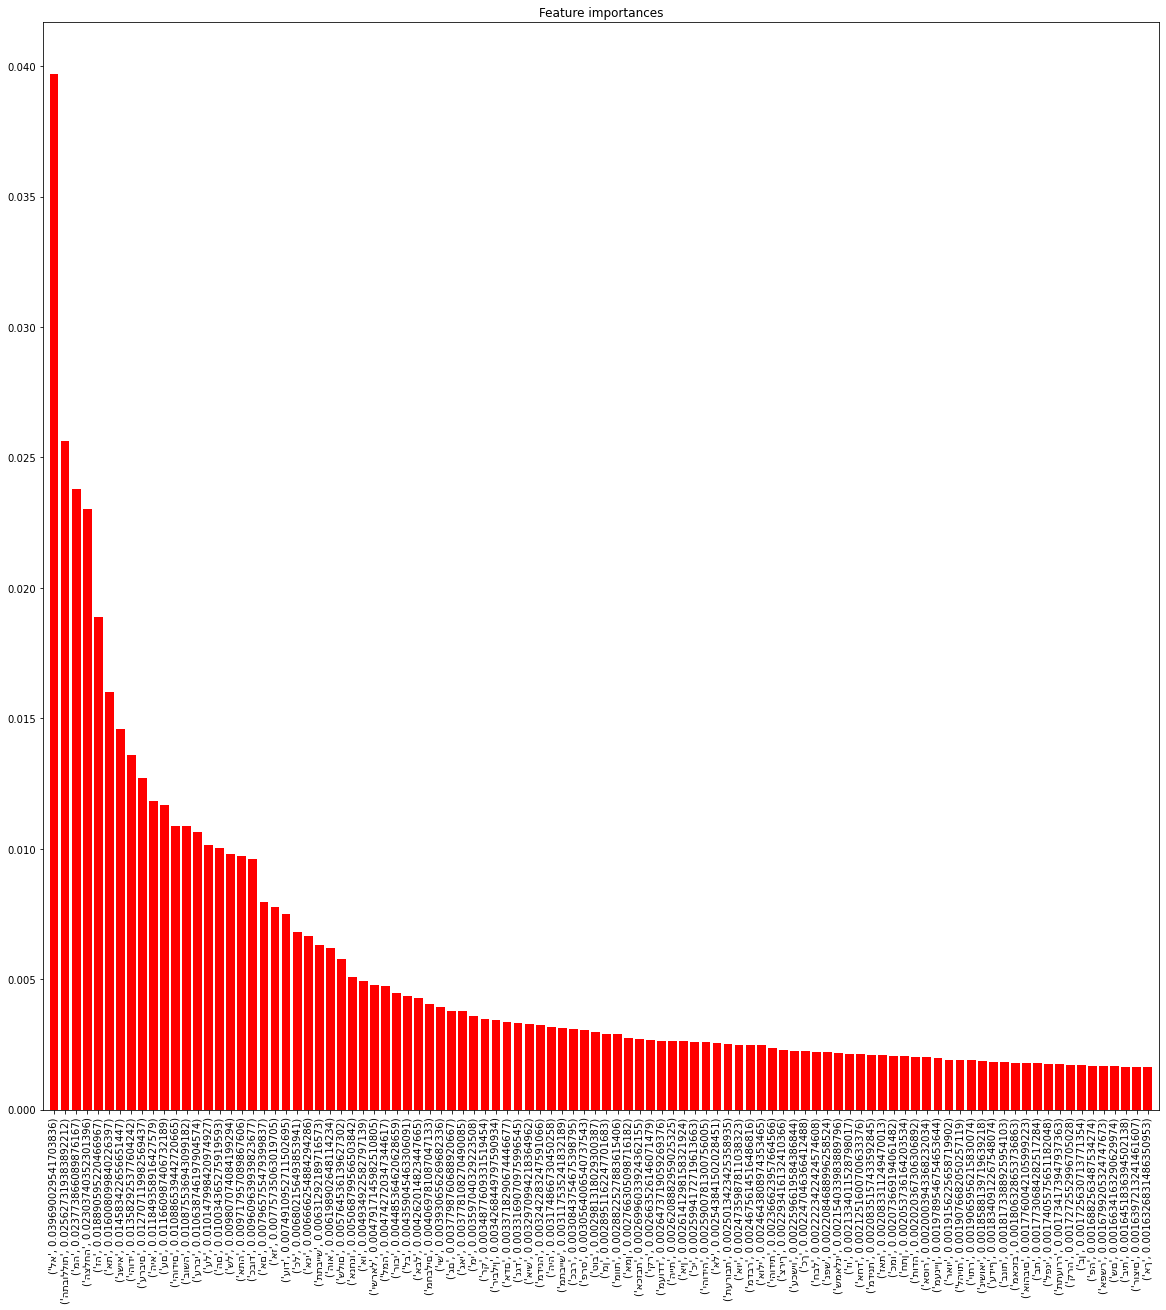

()

In [48]:
print_feature_importances(X_morph_train, morph_classifier, tfidf_morph_converter)

Feature ranking:
feature 1196 : not (0.030099)
feature 133 : assimilation (0.020836)
feature 926 : jewish (0.015166)
feature 483 : do (0.014542)
feature 113 : arab (0.013337)
feature 1571 : shame (0.012273)
feature 1761 : that (0.012223)
feature 1339 : president (0.012190)
feature 908 : is (0.012160)
feature 114 : arabs (0.011265)
feature 917 : it (0.010503)
feature 1800 : to (0.010372)
feature 1762 : the (0.010160)
feature 718 : good (0.009674)
feature 1916 : what (0.009429)
feature 93 : and (0.009337)
feature 124 : ashamed (0.008548)
feature 1987 : you (0.008449)
feature 867 : if (0.008165)
feature 1040 : luck (0.007710)


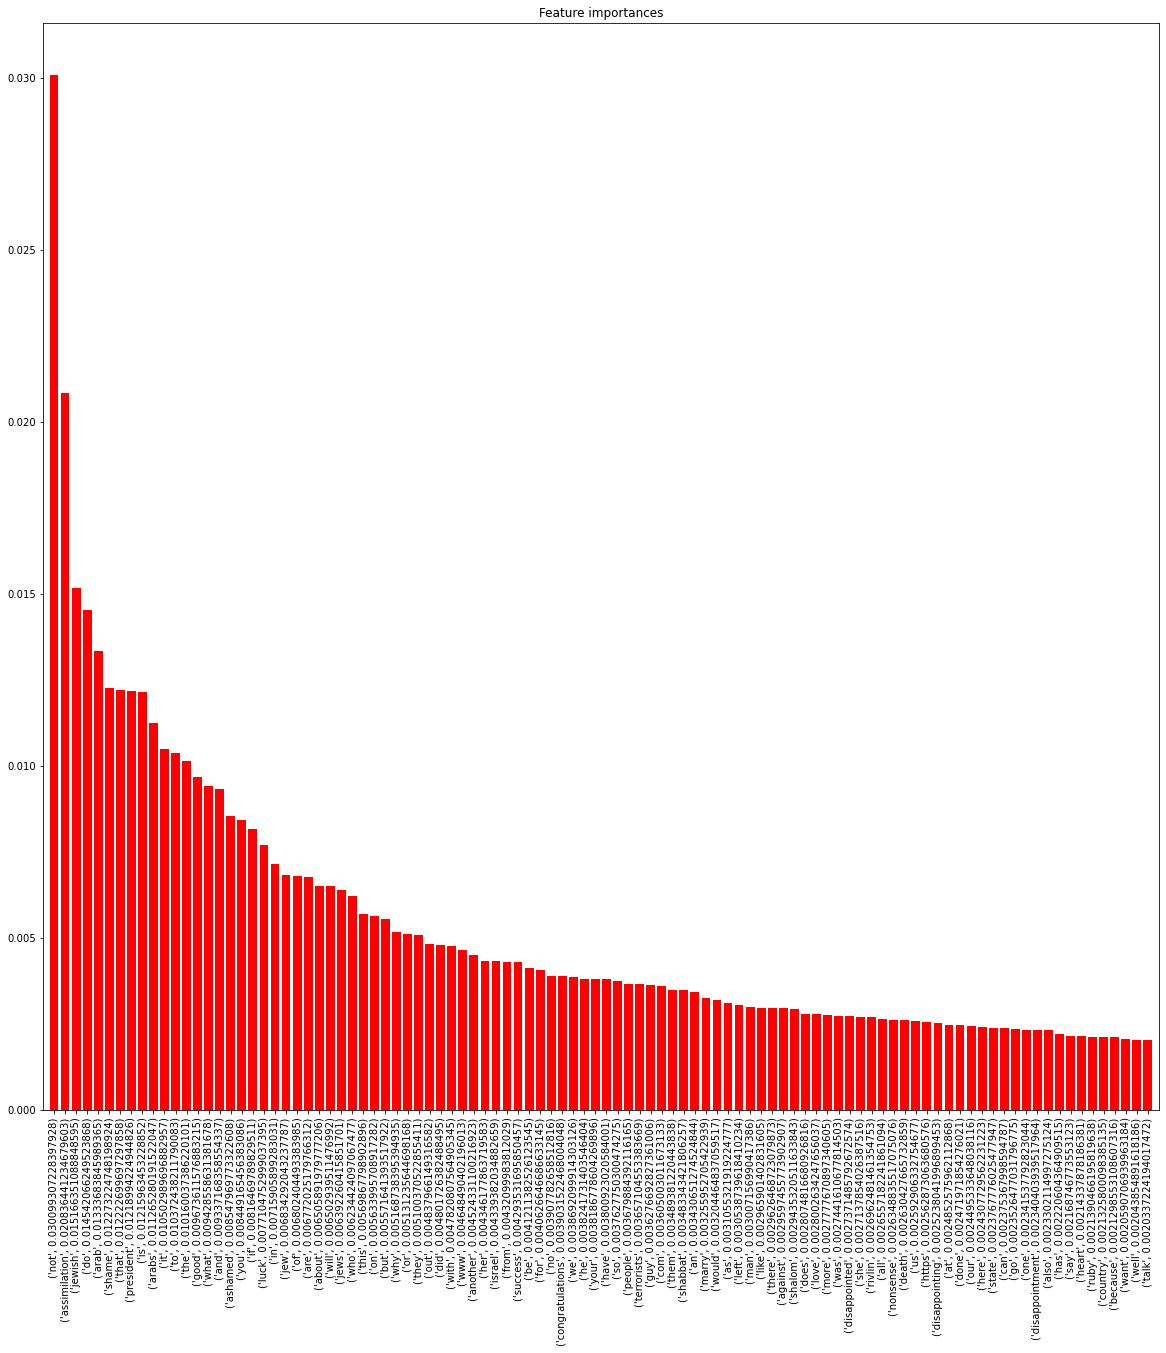

()

In [49]:
print_feature_importances(X_token_train_eng, token_eng_classifier, tfidf_token_eng_converter)

## SECOND MODEL
Using SVM classifier based on TD-IDF and POS Tagger
I will use only the english dataset, so i will be able to use nltk pos_tag

In [50]:
#process_eng_text_series function will get text Serier and clean it with regex expressions
def process_eng_text_series(series):

    for i,text in enumerate(series):  
        # Remove all the special characters
        text = re.sub(r'\W', ' ', str(text))

        # Remove all digits
        #processed_text = re.sub(r'\d+', ' ', processed_text)
        
        # remove all single characters
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

        # Remove single characters from the start
        text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 

        # Substituting multiple spaces with single space
        text= re.sub(r'\s+', ' ', text, flags=re.I)

        # Removing prefixed 'b'
        text = re.sub(r'^b\s+', '', text)

        # Converting to Lowercase
        text = text.lower()
        
        series[i] = text

In [51]:
#Put labels on the coloumns
token_train_eng = token_train_eng.rename(columns = {0: 'text', 1: 'label'}, inplace = False)
token_test_eng = token_test_eng.rename(columns = {0: 'text', 1: 'label'}, inplace = False)

In [52]:
#Clean dataset using process_eng_text_series function
process_eng_text_series(token_train_eng['text'])
process_eng_text_series(token_test_eng['text'])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [53]:
#word_tokenize will get text and return it tokenized in list
token_train_eng['text']= [word_tokenize(entry) for entry in token_train_eng['text']]
token_test_eng['text']= [word_tokenize(entry) for entry in token_test_eng['text']]

In [54]:
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [55]:
#data_lemmatization function will get dataset and lemmatize the text.
#lemmatization is the process of converting a word to its base form.
def data_lemmatization(data):
    for index,entry in enumerate(data['text']):
        Final_words = []
        word_Lemmatized = WordNetLemmatizer()
        for word, tag in pos_tag(entry):
            if word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)

        data.loc[index,'text_final'] = str(Final_words)

In [56]:
data_lemmatization(token_train_eng)

In [57]:
data_lemmatization(token_test_eng)

In [58]:
#Seperate the text and the sentiment labels
token_train_eng_X = token_train_eng['text_final']
token_train_eng_Y = token_train_eng['label']
token_test_eng_X = token_test_eng['text_final']
token_test_eng_Y = token_test_eng['label']

In [59]:
token_train_eng_Y = token_train_eng_Y.values
token_test_eng_Y = token_test_eng_Y.values

In [60]:
#Create feature vectors containing TF-IDF values
Tfidf_vect_eng = TfidfVectorizer(max_features=2000)
Tfidf_vect_eng.fit(token_train_eng['text_final'])
token_train_eng_X_Tfidf = Tfidf_vect_eng.transform(token_train_eng_X)
token_test_eng_X_Tfidf = Tfidf_vect_eng.transform(token_test_eng_X)

## Build Classifier
I will use SVM to classify the data

In [61]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(token_train_eng_X_Tfidf,token_train_eng_Y)

predictions_SVM = SVM.predict(token_test_eng_X_Tfidf)

print("token_eng model")
print(confusion_matrix(token_test_eng_Y, predictions_SVM))  
print(classification_report(token_test_eng_Y, predictions_SVM))  
print(accuracy_score(token_test_eng_Y, predictions_SVM))

token_eng model
[[1592   98    8]
 [ 159  625    6]
 [  28   21   23]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1698
           1       0.84      0.79      0.81       790
           2       0.62      0.32      0.42        72

    accuracy                           0.88      2560
   macro avg       0.79      0.68      0.72      2560
weighted avg       0.87      0.88      0.87      2560

0.875


## With the Random Forest Classifier (FIRST MODEL) i achieved better results than the SVM classfier.